# Propagation into the Variogram model

In [1]:
import skgstat as skg
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.optimize import minimize
import pickle
import glob
import json
import warnings
from pprint import pprint

warnings.filterwarnings('ignore')
plt.style.use('./paper.mplstyle')

## 1.1 Load Data


And we need to load the base variogram again:

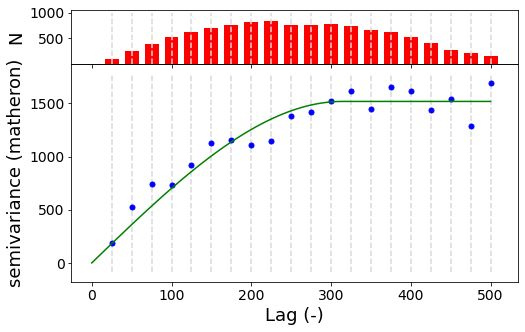

In [2]:
# get the data
coordinates, values = skg.data.pancake(N=150, seed=42).get('sample')

# estimate the variogram
vario = skg.Variogram(coordinates, values, n_lags=20)
vario.maxlag = 500

# plot
fig = vario.plot()

The model were fited with the `apps/model_fit.py` dash app. For each uncertainty level a number of models were fitted, that fall within the uncertainty levels.

In [3]:
models = dict()

for fname in glob.glob('./data/model_fits/*.json'):
    # load all models of given name
    with open(fname, 'r') as f:
        params = json.load(f)
    
    # extract model name
    model_name = params[0].get('model')
    
    # add to models dict
    models[model_name] = params

pprint({k: f'{len(v)} models' for k, v in models.items()})

{'cubic': '8 models',
 'exponential': '13 models',
 'gaussian': '7 models',
 'matern': '17 models',
 'spherical': '14 models',
 'stable': '14 models'}


## 1.2 uncertainty levels

In [63]:
SIGMA = 10       # load the given observation uncertainty result

with open(f'./data/MC_results_50000_{SIGMA}.pickle', 'rb') as f:
    _d = pickle.load(f)
    ebins = _d['ebins']
    eparams = _d['eparams']
    emodels = _d['emodels']

# calculate absoulte error margins
error_bounds = np.column_stack((
    np.min(ebins, axis=1),
    np.max(ebins, axis=1)
))


#pprint(error_bounds.round(0))

# filter models
filtered_models = list()
for mod in models.values():
    filtered_models.extend([p for p in mod if p.get('sigma_obs') == SIGMA])

# get the fits and RMSE
rmse = [m.get('rmse') for m in filtered_models]
in_rmse = [np.abs(r - np.mean(rmse)) <= np.std(rmse) for r in rmse]
in_bound = [m.get('fit') >= 99 for m in filtered_models]
good_models = np.array(in_rmse) | np.array(in_bound)

print(f'Filtered Models for sigma={SIGMA}\n----------------------------')
print(f'Count:          {len(filtered_models)}')
print(f'E[RMSE]:        {np.mean(rmse).round(1)} ')
print(f'std[RMSE]:      {np.std(rmse).round(1)} ')
print(f'In Bound fit:   {sum(in_bound)}')
print(f'Fair RMSE fit:  {sum(in_rmse)}')
print(f'Using Models:   {sum(good_models)}')

Filtered Models for sigma=10
----------------------------
Count:          16
E[RMSE]:        103.7 
std[RMSE]:      28.2 
In Bound fit:   0
Fair RMSE fit:  12
Using Models:   12


## 1.3 Kriging

In [64]:
RERUN = False

if RERUN:
    xx = yy = range(500)

    fields = []
#    for params in tqdm(np.array(filtered_models)[good_models], total=sum(good_models)):
    for params in tqdm(np.array(filtered_models)[in_bound], total=sum(in_bound)):
        v = vario.clone()
        v.model = params.get('model')
        args = dict(
            fit_range=params.get('effective_range'),
            fit_sill=params.get('sill'),
            fit_nugget=params.get('nugget')
        )
        if params.get('model') in ('matern', 'stable'):
            args['fit_shape'] = params.get('shape')
        v._kwargs.update(args)
        v.fit_method = 'manual'

        krige = v.to_gs_krige()
        field, _ = krige.structured((xx, yy))

        fields.append(field)

    with open(f'./data/mod_interp_fields_50000_{SIGMA}.pickle', 'wb') as f:
        pickle.dump(fields, f)
else:
    with open(f'./data/mod_interp_fields_50000_{SIGMA}.pickle', 'rb') as f:
        fields = pickle.load(f)

fields

[array([[250.05825718, 249.24526216, 248.43124776, ..., 185.76221156,
         185.6874032 , 185.61579926],
        [250.24376474, 249.42966358, 248.61446616, ..., 185.91257313,
         185.83548296, 185.76155809],
        [250.42837432, 249.61327124, 248.79700743, ..., 186.06088539,
         185.98163413, 185.90550361],
        ...,
        [139.24151786, 139.84444097, 140.45035201, ..., 193.14951245,
         193.20219667, 193.25353072],
        [138.0341191 , 138.62692415, 139.22284235, ..., 194.49404852,
         194.53733825, 194.57928278],
        [136.83717932, 137.41999673, 138.00603091, ..., 195.83743525,
         195.87132927, 195.90391081]]),
 array([[227.81644235, 227.59432389, 227.36505939, ..., 190.35349643,
         190.40099839, 190.44827003],
        [228.17813765, 227.95613075, 227.72690349, ..., 190.35206434,
         190.39841316, 190.44457992],
        [228.54118855, 228.31933764, 228.09019385, ..., 190.34996276,
         190.39514116, 190.44018859],
        ...,


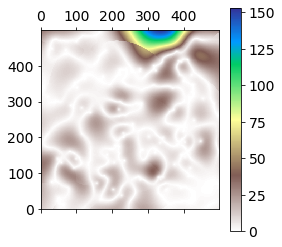

In [73]:
all_ = np.stack(fields, axis=2)

low, high = (
    np.percentile(all_, 10, axis=2),
    np.percentile(all_, 90, axis=2)
)

plt.matshow(high - low, origin='lower', cmap='terrain_r')
plt.colorbar()

## OLD STUFF

In [75]:
def loss(x: np.ndarray, x_conf: np.ndarray, w = None) -> float:
    # calc weights
    if w is None:
        w = [1 for _ in range(len(x))]
    # get deviations
    deviation = [0 if _x > bnd[0] and _x < bnd[1] else np.sqrt((_x - np.mean(bnd))**2) for _x, bnd in zip(x, x_conf)]
    return np.sum(deviation * (w / np.sum(w)))

def fit(pars: np.ndarray, x_conf: np.ndarray, lags: np.ndarray, model_name: str, *args):
    # estimate the model
    model = getattr(skg.models, model_name)
    x = [model(_, *pars, *args) for _ in lags]
    
    # return the loss value 
    return loss(x, x_conf)
    
#test = np.mean(ebins, axis=1)
#test[5] *= 20
#loss(test, error_bounds)

1401.3081413635655

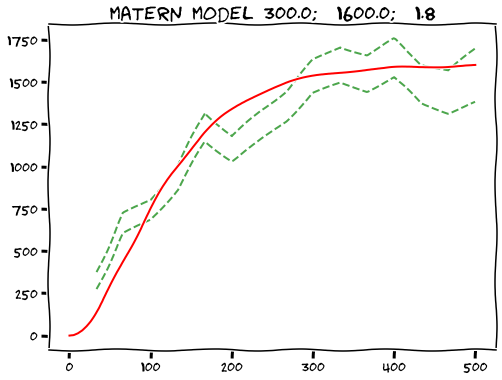

In [89]:
bnd = ((0, np.max(vario.bins)), (0, np.max(ebins)))
bnd_s = ((0, np.max(vario.bins)), (0, np.max(ebins)), (0.2, 20))
MOD = 'matern'

# minimize chosen model
model = getattr(skg.models, MOD)
res = minimize(fit, (300, 1600, 2), args=(error_bounds, vario.bins, MOD), method='SLSQP', bounds=bnd_s)

# apply the model
x = np.linspace(0, np.max(vario.bins), 100)
y = [model(_, *res.x) for _ in x]

# plot
with plt.xkcd():
    fig, ax = plt.subplots(1, 1, figsize=(8,6))
    ax.plot(vario.bins, error_bounds[:,0], '--g', alpha=0.7)
    ax.plot(vario.bins, error_bounds[:,1], '--g', alpha=0.7)
    ax.plot(x, y, '-r', lw=2)
    ax.set_title(f'{MOD} model %s' % (';  '.join(['%.1f' % _ for _ in res.x])))